In [18]:
import tellurium as te
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

In [19]:
def convert_bounds_to_logscale(bounds):
    """
    converts bounds for parameters from linear scale to log10 scale. If a bound is 0, it's replaced with 1e-8 to avoid infinity values in log scale.
    Input and output: Ordered dictionaries
    """
    log_bounds = OrderedDict({})

    for param, bound in bounds.items():
        if bound[0] == 0:
            bound = (bound[1]*1e-3, bound[1])
        log_bounds[param] = (np.log10(bound[0]), np.log10(bound[1]))

    return log_bounds

In [20]:
model = te.loada('LCT_OIE.ant')  # ../model/OIE_model.ant

In [21]:
model.M = 0
res = model.simulate(0, 100)

In [22]:
res_df = pd.DataFrame(res, columns=res.colnames)

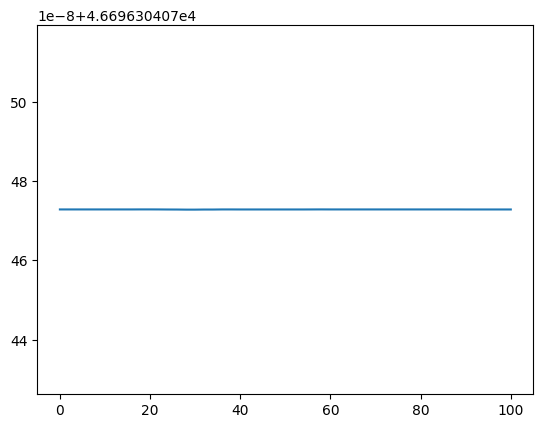

In [23]:
fig, ax = plt.subplots()

ax.plot(res_df['time'], res_df['[R]'])
plt.show()

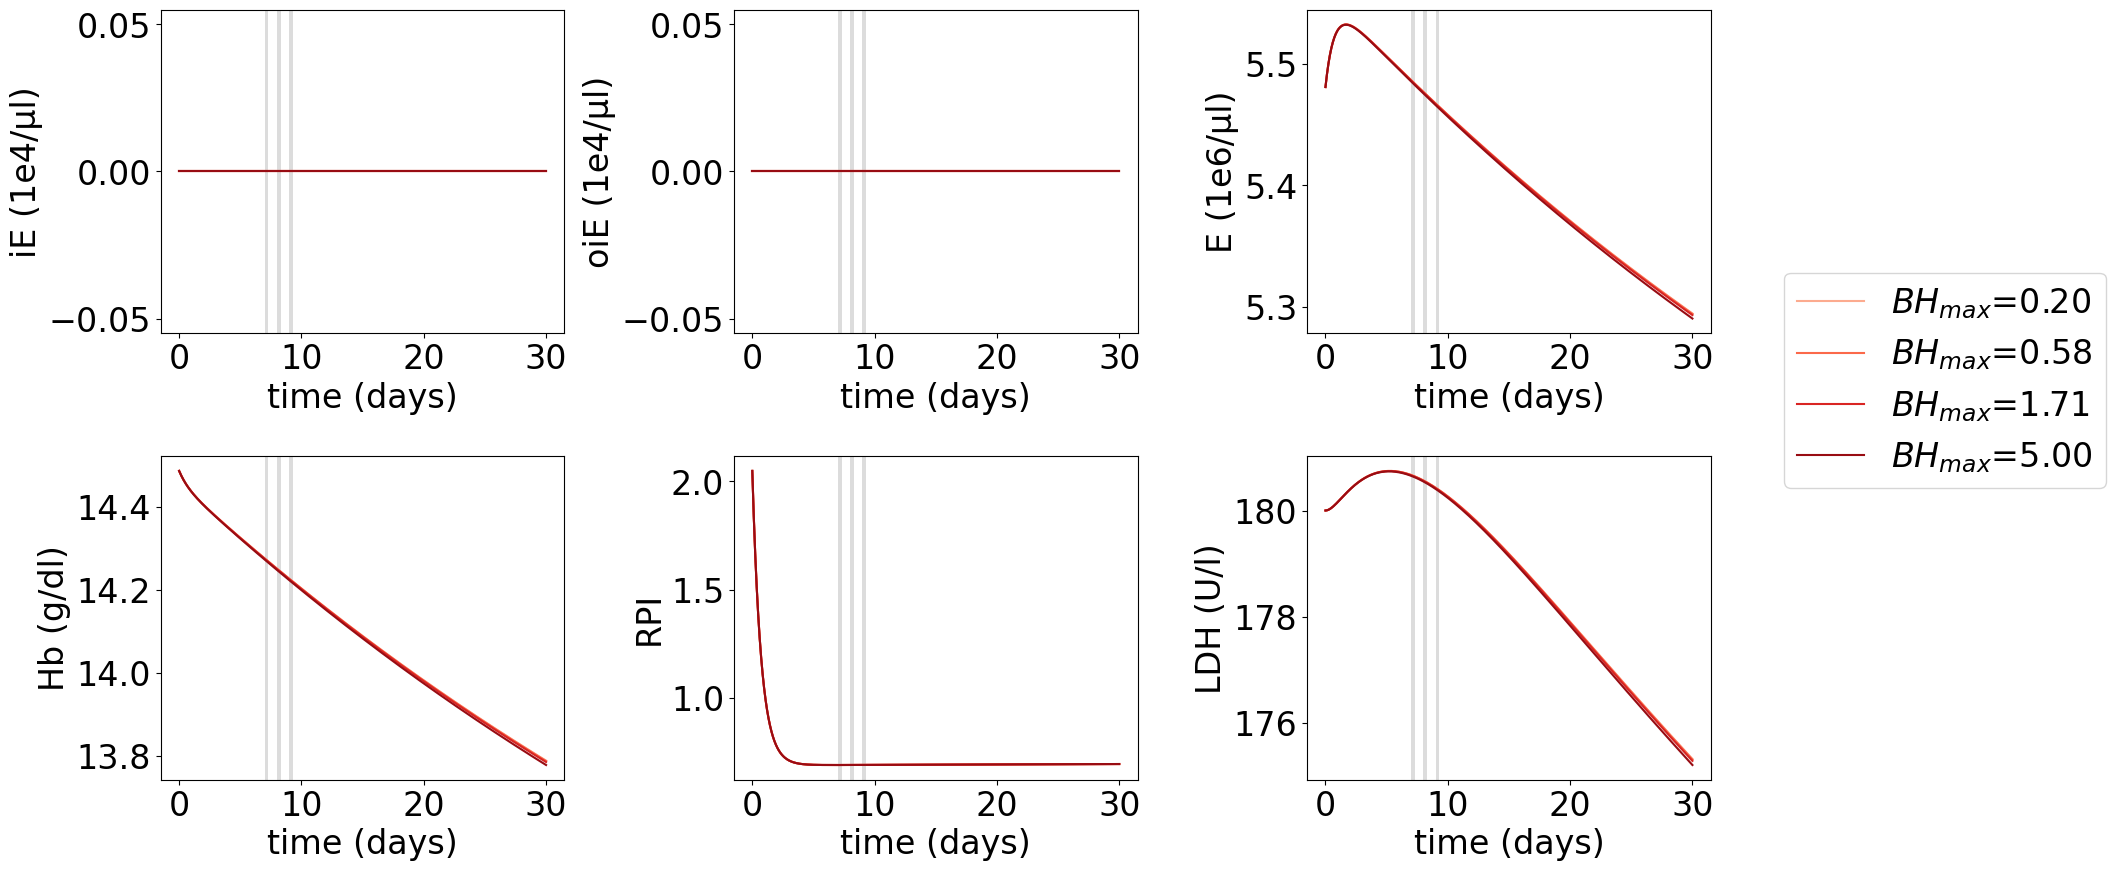

In [53]:
species_to_analyze = OrderedDict({
    '[iE]': ['iE (1e4/µl)', 1e4],
    'oiE': ['oiE (1e4/µl)', 1e4],
    '[E]': ['E (1e6/µl)', 1e6],
    'Hb': ['Hb (g/dl)', 1],
    'RPI': ['RPI', 1],
    'LDH': ['LDH (U/l)',1],
})

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'BH_max': (2e-1, 5),
})


# Konvertiere bounds in logscale
params_bounds_log = convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 4

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3
MAX = {}
MIN = {}

for i, (param, values) in enumerate(param_values.items()):
    p_max = {}
    p_min = {}

    for idx, value in enumerate(values):
        model = te.loada('LCT_OIE.ant')

        model_str = model.getAntimony()        #lade Antimony string
        model_lines = model_str.split('\n')    #splitte in für jede Zeile
        new_model_lines = []

        for line in model_lines:         #gehe alle zeielen durch, ändere wnn parameter geändert werden soll, füge in neuen strig zu
            if line.startswith(f'{param}=') or line.startswith(f'{param} '):   # if line.startswith(param):
                line = f'{param}={10**value}'
            new_model_lines.append(line)
        new_model_str = '\n'.join(new_model_lines)    
        model = te.loada(new_model_str) 

        result = model.simulate(0, 30, 500, ['time']+list(species_to_analyze.keys()))
        p_max[10**value] = np.max(result["RPI"])
        p_min[10**value] = np.min(result["RPI"])


        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3


            axs[row][col].plot(result['time'], result[specie]/species_to_analyze[specie][1], label=f'$BH_{{max}}$={round(10**value,2):.2f}', color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[row][col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row][col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row][col].axvspan(7, 7.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
            axs[row][col].axvspan(8, 8.3, facecolor='gainsboro', alpha=1, linewidth=2)
            axs[row][col].axvspan(9, 9.3, facecolor='gainsboro', alpha=1, linewidth=2)
            
        handles, labels = axs[row][col].get_legend_handles_labels()  # Legend Box outsides Subplots
    MAX[param] = p_max
    MIN[param] = p_min

axs[1][1].legend(handles, labels, loc='lower center', bbox_to_anchor=(3.0, 0.85),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


#plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')

plt.show()

#print(handles, labels)

#plt.savefig("plot.pdf")